# RNN & CNN

In [97]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 텐서 플로의 정보 출력 억제하기
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # GPU 장치 지정

In [98]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
from pathlib import Path

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# 그림 저장 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [99]:
if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

##### 순환 신경망 RNN
- 시계열 데이터를 분석해서 주식 가격 등을 예측하고, 자율 주행 시스템에서는 차의 이동 경로를 예측하여 사고를 피하도록 도움

- 일반적으로 이 신경망은 고정 길이 입력이 아닌 임의 길이를 가진 시퀀스를 다룰 수 있다. 문장, 문서, 오디오 샘플을 입력으로 받을 수 있고, 자연어 처리(NLP)에 매우 유용

지금까지는 활성화 신호가 입력층에서 출력층 한 방향으로 흐르는 피드포워드 신경망 위주였지만, 순환 신경망은 뒤쪽으로 순환하는 연결도 있다는 차이점이 있음.

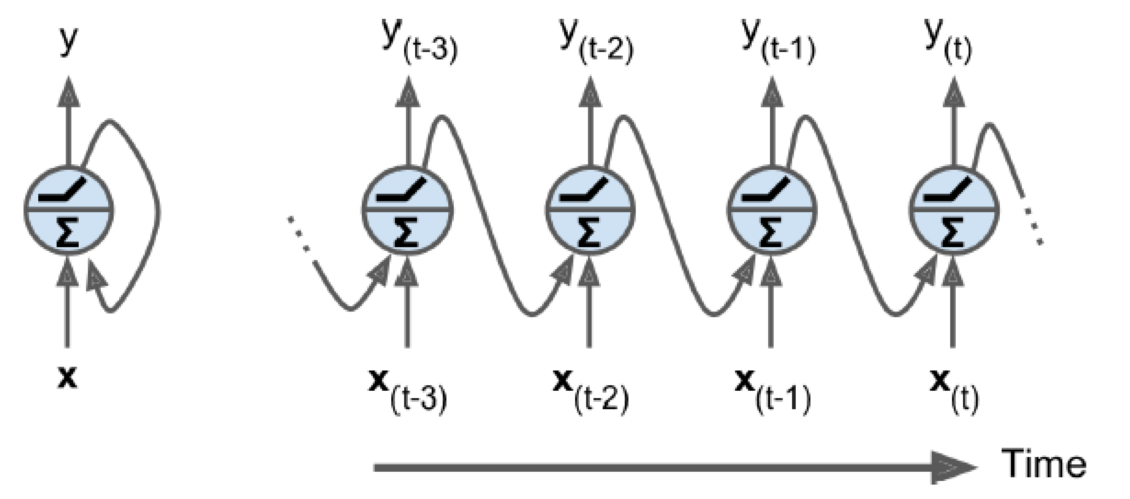

In [100]:
import matplotlib.image as mpimg

filename = "rnn_1.png"
images_path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
show_img = mpimg.imread(os.path.join(images_path, filename))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(show_img)

- 입력을 받아 출력을 만들고, 자신에게도 출력을 보내는 뉴런 하나로 구성된 가장 간단한 RNN 구조

- 각 타임스텝 t(또는 프레임) 마다 이 순환 뉴런은 물론 x(t)와 이전 타임 스텝의 출력인 y(t-1)을 입력으로 받음

- 첫 번째 타임스텝에서는 이전 출력이 없으므로 일반적으로 0으로 설정

- 오른쪽처럼 시간에 따라 네트워크를 펼쳐 표현 가능(동일한 뉴런을 타임 스텝마다 하나씩 표현)

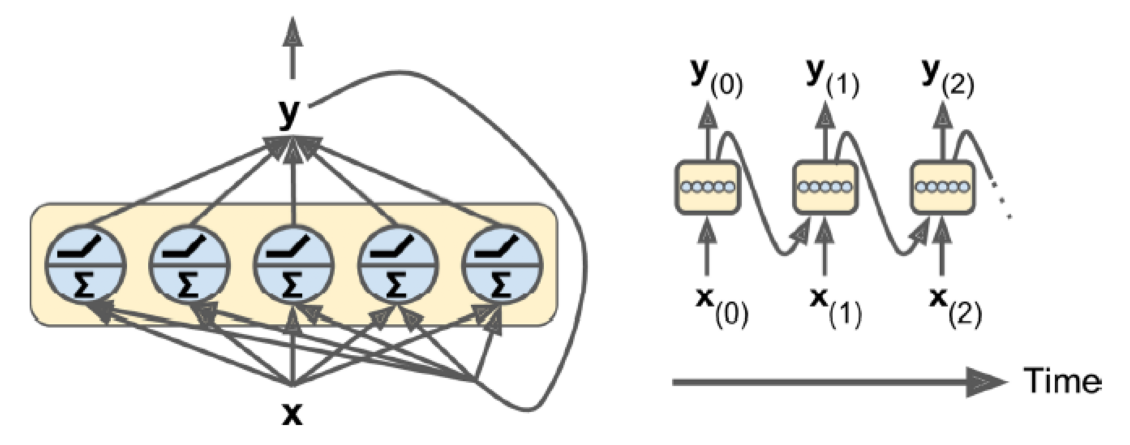

In [101]:
import matplotlib.image as mpimg

filename = "rnn_2.png"
images_path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
show_img = mpimg.imread(os.path.join(images_path, filename))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(show_img)

- 순환 뉴런으로 된 층

- 타임 스텝 t마다 모든 뉴런은 입력 벡터 x(t)와 이전 타임 스텝의 출력 벡터 y(t-1)을 받음 => 입력과 출력이 모두 벡터

- 각 순환 뉴런은 두 벌의 가중치를 가짐

  * 하나는 입력 x(i)를 위한 것 -> 가중치 벡터 wx
  * 하나는 이전 타임 스텝의 출력 y(t-1)을 위한 것 -> 가중치 벡터 wy

하나의 순환 뉴런이 아니라 순환 층 전체를 생각하면 가중치 벡터를 가중치 행렬 Wx와 Wy로 바꿀 수 있음

-> 순환 층 전체의 출력 벡터를 다음과 같이 계산 가능

**Equation 14-1: Output of a recurrent layer for a single instance**

$
\mathbf{y}_{(t)} = \phi\left({\mathbf{W}_x}^T{\mathbf{x}_{(t)}} + {{\mathbf{W}_y}^T\mathbf{y}_{(t-1)}} + \mathbf{b} \right)
$

피드포워드 신경망처럼 타임 스텝 t에서의 모든 입력을 행렬 X(t)로 만들어 미니배치 전체에 대해 

순환층의 출력을 한 번에 계산할 수 있음.

**Equation 14-2: Outputs of a layer of recurrent neurons for all instances in a mini-batch**

$\begin{split}
\mathbf{Y}_{(t)} & = \phi\left(\mathbf{X}_{(t)} \mathbf{W}_{x} + \mathbf{Y}_{(t-1)} \mathbf{W}_{y} + \mathbf{b} \right) \\
& = \phi\left(
\left[\mathbf{X}_{(t)} \quad \mathbf{Y}_{(t-1)} \right]
  \mathbf{W} + \mathbf{b} \right) \text{ with } \mathbf{W}=
\left[ \begin{matrix}
  \mathbf{W}_x\\
  \mathbf{W}_y
\end{matrix} \right]
\end{split}
$

### 메모리 셀

- 타임 스텝 t에서 순환 뉴런의 출력은 이전 타임 스텝의 모든 입력에 대한 함수이므로 일종의 메모리 형태라고 할 수 있음

- 타임 스텝에 걸쳐서 어떤 상태를 보존하는 신경망의 구성 요소를 메모리 셀(=셀) 이라고 함

- 하나의 순환 뉴런 또는 순환 뉴런의 층은 짧은 패턴만 학습할 수 있는 기본적인 셀

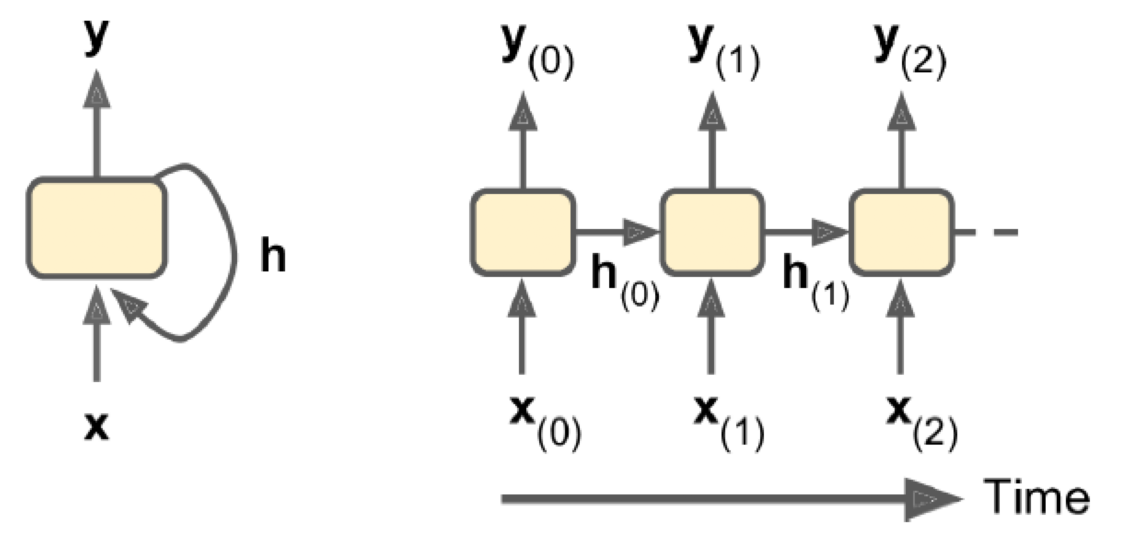

In [102]:
import matplotlib.image as mpimg

filename = "rnn_3.png"
images_path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
show_img = mpimg.imread(os.path.join(images_path, filename))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(show_img)

- 일반적으로 타임 스텝 t에서의 셀의 상태 h(t)는 그 타임 스텝의 입력과 이전 타입 스텝의 상태에 대한 함수

- h(t) = f(h(t-1), x(t)) 

- 타임 스텝 t에서의 출력 y(t)도 이전 상태와 현재 입력에 대한 함수

- 기본 셀의 경우 출력은 셀의 상태와 동일하지만, 위 그림처럼 더 복잡한 셀에서는 항상 그렇지는 않음

### 입력과 출력 시퀀스

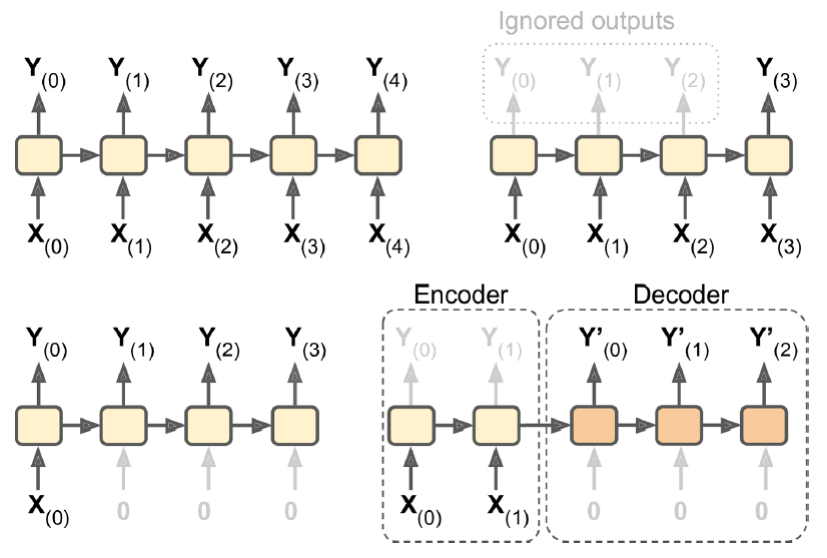

In [103]:
import matplotlib.image as mpimg

filename = "rnn_4.png"
images_path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
show_img = mpimg.imread(os.path.join(images_path, filename))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(show_img)

##### **시퀀스-투-시퀀스 네트워크**

- RNN은 입력 시퀀스를 받아 출력 시퀀스를 만들 수 있음

- 주식가격 같은 시계열 데이터를 예측하는 데 유용

ex. 최근 N일치 주식가격을 주입하면 네트워크는 각 입력값보다 하루 앞선 가격을 출력해야 함

 

##### **시퀀스-투-벡터 네트워크**

- 입력 시퀀스를 네트워크에 주입하고, 마지막을 제외한 모든 출력을 무시할 수 있음

ex. 영화 리뷰에 있는 연속된 단어를 주입하면, 네트워크는 감성 점수를 출력함

 

##### **벡터-투-시퀀스 네트워크**

- 각 타임 스텝에서 하나의 입력 벡터를 반복해서 네트워크에 주입하고, 하나의 시퀀스를 출력할 수 있음

ex. 이미지(또는 CNN의 출력)를 입력하여 이미지에 대한 캡션을 출력할 수 있음

 

##### **인코더-디코더**

- 인코더라 부르는 시퀀스-투-벡터 네트워크 뒤에 디코더라 부르는 벡터-투-시퀀스 네트워크를 연결할 수 있음

ex. 한 언어의 문장을 다른 언어로 번역하는 데 사용 - 한 언어의 문장을 네트워크에 주입하면, 인코더는 이 문장을 하나의 벡터로 표현하고, 그 후 디코더가 이 벡터를 다른 언어의 문장으로 디코딩

- 인코더-디코더라 불리는 이중 단계 모델은 시퀀스-투-시퀀스가 RNN을 이용해 한 단어씩 번역하는 것보다 훨씬 더 잘 작동

  * 문장의 마지막 단어가 번역의 첫 번째 단어에 영향을 줄 수 있기 때문
  * 번역하기 전에 전체 문장이 주입될 때까지 기다릴 필요가 있음
 

## RNN  훈련하기

RNN을 훈련하는 방법은, 타임 스텝으로 네트워크를 펼치고 보통의 역전파를 사용하는 것

=> BPTT(backpropagation through time)

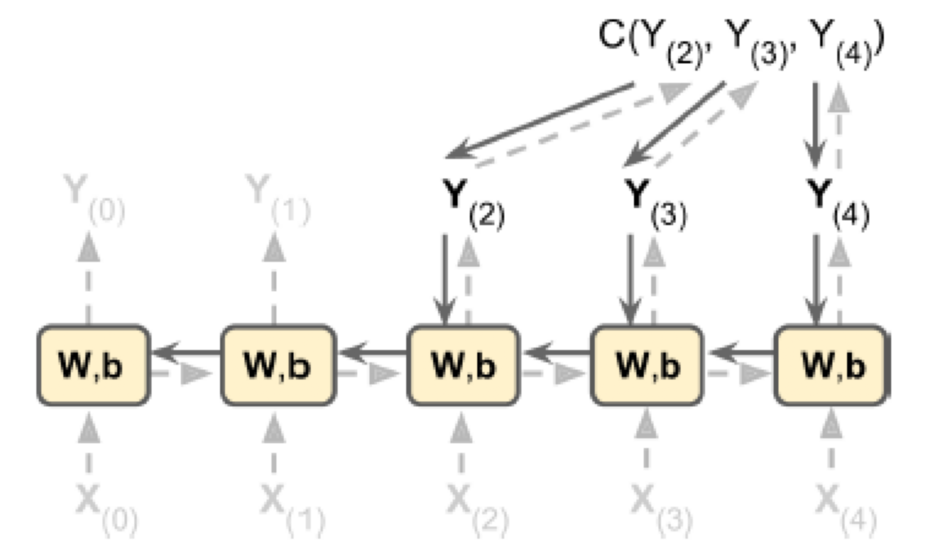

In [104]:
import matplotlib.image as mpimg

filename = "rnn_5.png"
images_path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
show_img = mpimg.imread(os.path.join(images_path, filename))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(show_img)

- 보통의 역전파와 같이, 첫 번째 정방향 패스가 펼쳐진 네트워크를 통과 (파선, 다섯개의 입력 시퀀스가 주입된 다섯 번의 타임 스텝)

- 비용함수 C(Y(0), Y(1), Y(2)) (T는 최대 타임 스텝)를 사용하여 출력 시퀀스가 평가됨

- 비용 함수의 그래디언트는 펼쳐진 네트워크를 따라 역방향으로 전파됨 (실선)

- 결국 모델 파라미터는 BPTT 동안 계산된 그래디언트를 사용해 업데이트됨

- 그래디언트가 마지막 출력 뿐만 아니라 비용 함수를 사용한 모든 출력에서 역방향으로 전파됨

(그림에서는 비용함수 계산시 Y(2),(3),(4) 를 사용했기 때문에 그래디언트는 이 세개의 출력을 거쳐 흐르지만 Y(0)과 Y(1)은 거치치 않음)

- 각 타임 스텝마다 같은 매개변수 W와 b가 사용되므로 역전파가 진행되면 모든 타임 스텝에 걸쳐 합산됨

## 시계열 예측하기

In [105]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   웨이브 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + 웨이브 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + 잡음
    return series[..., np.newaxis].astype(np.float32)

In [106]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [107]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

그림 저장 time_series_plot


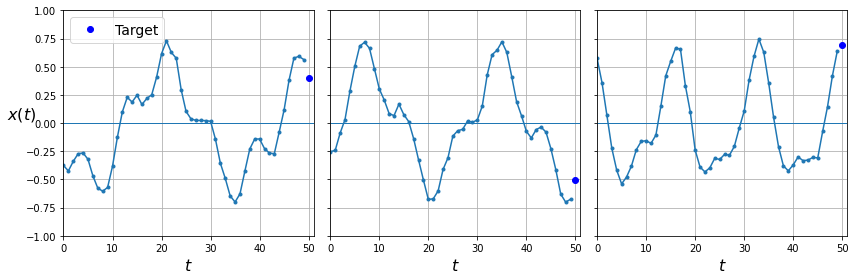

In [108]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

**노트**: 이 노트북에서 파란 점은 타깃을 나타내고 빨강 X 표시는 예측을 나타냅니다. 처음에 책에서 파란 X 표시를 타깃에 사용하고 빨강 점을 예측에 사용했다가 나중에 바꾸었습니다. 혼동을 드려 죄송합니다.

### 기준 성능

RNN을 시작하기 전에 기준 성능에 몇 개 준비하는 것이 좋음. 

그렇지 않으면 실제기본모델보다 성능 낮을수도 있음, 간단한 방법 2개 :

1. 단순한 예측 (마지막 관측값을 사용해 예측합니다):

In [109]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

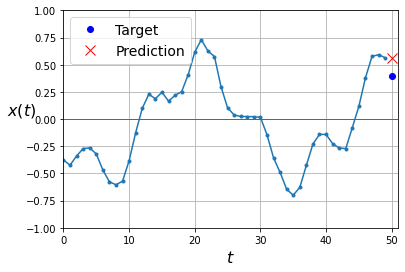

In [110]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

2. 완전 연결 네트워크 사용하기

In [111]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
with tf.device("/GPU:0"):
  history = model.fit(X_train, y_train, epochs=20,
                      validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 4ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0061 - val_loss: 0.0062

- 이 네트워크는 입력마다 1차원 특성 배열을 기대하기 때문에 Flatten 층 추가

- 시계열 값의 선형 조합으로 예측하기 위해 선형 회귀 모델 사용

- MSE 손실, Adam 옵티마이저로 컴파일 후 20 epoch 동안 훈련 세트에서 훈련하여 검증 세트에서 평가 시 약 0.004의 MSE 결과로, 순진한 예측보다 나은 결과를 보여줌

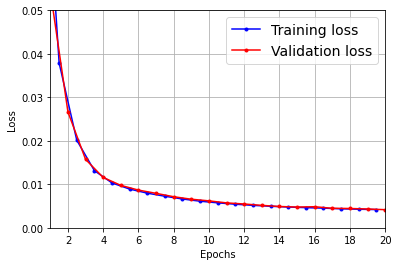

In [112]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

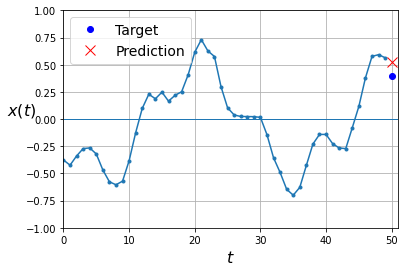

In [113]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### 간단한 RNN 구현하기

SimpleRNN을 사용해 간단하게 사용가능. 기본적으로 SimpleRNN 층은 하이퍼볼릭 탄젠트 활성화함수를 사용

In [114]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
with tf.device("/GPU:0"):
    history = model.fit(X_train, y_train, epochs=20,
                        validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 18s 81ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 18s 84ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 19s 86ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 18s 83ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 19s 89ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 19s 87ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 19s 87ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 22s 100ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 24s 107ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 21s 98ms/step - loss: 0.0

- 하나의 뉴런으로 이루어진 하나의 층을 가짐

- 순환 신경망은 어떤 길이의 타임 스텝도 처리할 수 있기 때문에 입력 시퀀스의 길이를 지정할 필요가 없음 -> 첫 번째 입력 차원을 None으로 지정

In [115]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 13ms/step - loss: 0.0109


0.010881561785936356

- 이 모델을 훈련, 평가 하면 0.010에 달하는 MSE를 얻음

=> 순진한 예측보다 낫지만, 간단한 선형 모델을 앞지르지 못함

- 선형 모델은 각 뉴런에 대해 입력마다 하나의 파라미터를 가지고 편향이 있음(여기서 총 51개의 파라미터)

- 반면 기본 RNN의 순환 뉴런은 입력과 은닉 상태 차원마다 하나의 파라미터를 가지고 편향이 있음(기본 RNN에서는 총 3개의 파라미터)

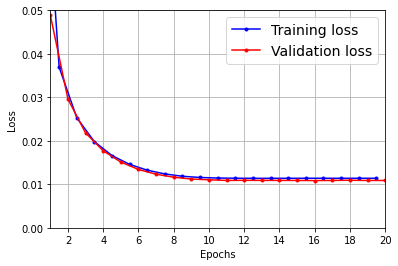

In [116]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

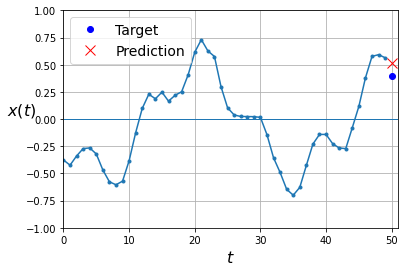

In [117]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

##### **트렌드와 계절성**

가중 이동 평균이나 자동 회귀 누적 이동 평균(ARIMA)같이 시계열을 예측하는 다른 방법이 많음.

이런 방법 중 일부는 트렌드나 계절성을 제거해야 함. 예를 들어 매달 10% 성장하는 웹사이트의

접속자 수를 조사한다면 시계열에서 이런 트렌드를 삭제해야함. 모델이 훈련하고 예측을 만들기 시작할 때

최종 예측에 이 트렌드를 다시 더함.

ex) 매달 선크림 판매량 예측. 선크림은 여름에 잘 팔리기 때문에 비슷한 패턴이 매년 반복.

시계열에서 이런 계절성 삭제. 예를 들어 매 타임 스텝의 값과 작년도 값의 차이를 계산해 사용(차분).

### 심층 RNN

RNN은 셀을 여러 층으로 쌓는 것이 일반적 -> 심층 RNN

tf.keras로 심층 RNN을 구현하려면, 순환 층을 쌓으면 됨

ㅈㄴ 느림

In [118]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 70s 310ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 68s 312ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 71s 323ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 69s 315ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 68s 309ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 67s 308ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 68s 309ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 69s 315ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 68s 311ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 69s 317ms/step - l

In [119]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 3s 42ms/step - loss: 0.0029


0.0029105590656399727

- 모든 순환 층에서 return_sequences=True 설정 필요

- 마지막 출력만 관심 대상이면 마지막 층에서는 설정하지 않음

- 이 모델은 같은 조건으로 컴파일, 훈련, 평가 시 0.003의 MSE에 도달함

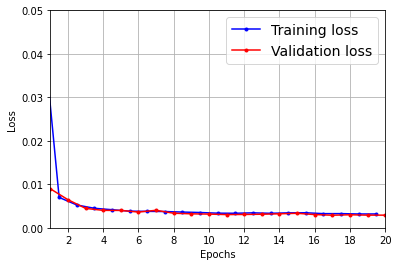

In [120]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

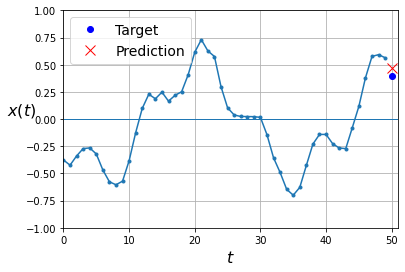

In [121]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

**위 코드의 마지막 층을 변경할 수 있음**

- 단변량 시계열을 예측하기 때문에 하나의 유닛이 필요하고 이는 타임스텝마다 하나의 출력을 만들어야 한다는 뜻
- 하나의 유닛을 가진다는 것은 은닉 상태가 하나의 숫자라는 뜻
- 이 RNN은 한 타임 스텝에서 다음 타임스텝으로 필요한 모든 정보를 나르기 위해 다른순환 층의 은닉상태를 주로 사용할 것
- 마지막 층의 은닉 상태는 필요하지 않음
- 또한 SimpleRNN은 기본적으로 tanh 활성화 함수를 사용하므로 예측된 값이 -1~1 사이 값을 가짐

-> 이런 이유로 출력층을 Dense로 바꾸는 경우가 많음

두 번째 순환 층에서 return_sequences=True를 제거함(두 번째 순환 층이 마지막 층이 되었기 때문)

-> 더 빠르면서 정확도는 비슷

In [122]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 47s 207ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 46s 209ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 44s 199ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 43s 198ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 43s 197ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 45s 206ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 45s 204ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 43s 196ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 40s 182ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 41s 186ms/step - l

In [123]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 2s 29ms/step - loss: 0.0026


0.002623624401167035

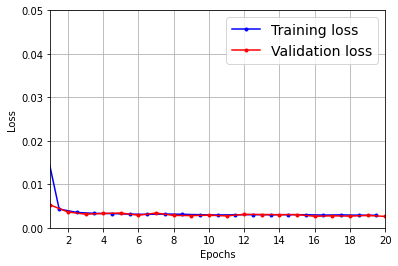

In [124]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

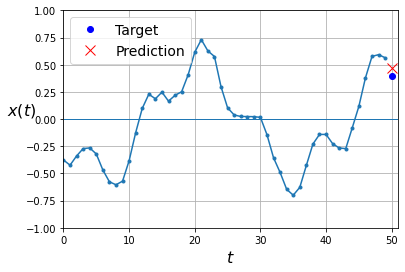

In [125]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### 여러 타임 스텝 앞을 예측하기

지금까지처럼 다음 타임 스텝의 값만 예측하는게 아닌, 타깃을 적절히 바꾸어 여러 타임 스텝 앞의 값을 예측할 수 있음

ex. 1 스텝 앞이 아닌, 10 스텝 앞의 값으로 타깃을 바꾸어 10 스텝 앞 예측

-> 다음 값 10개를 예측하려면?

|

**1. 이미 훈련된 모델을 사용해 다음 값을 예측한 후, 이 값을 입력으로 추가**

- 이 모델을 사용해 다시 다음 값을 예측하는 식

In [126]:
np.random.seed(43) # 42는 훈련 세트에 있는 첫 번째 시리즈를 반환하기 때문에 다른 값으로 지정합니다

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [127]:
Y_pred.shape

(1, 10, 1)

그림 저장 forecast_ahead_plot


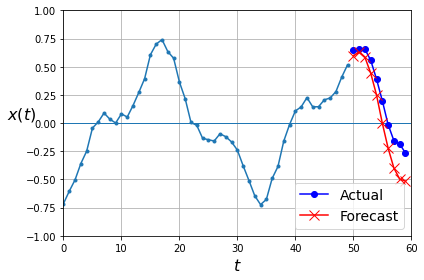

In [128]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

- 다음 스텝에 대한 예측은 보통 더 미래의 타임스텝에 대한 예측보다 정확함

  (미래의 타임 스텝은 오차가 누적될 수 있기 때문)

- 이 모델은 한 번에 하나의 미래 스텝을 예측하기 위해 RNN을 사용하는 것보다 나음

이 모델을 사용해 다음 10개의 값을 예측해 보겠습니다. 먼저 아홉 개의 타임 스텝을 더 가진 시퀀스를 다시 생성해야 합니다.

In [129]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

이제 하나씩 다음 10개의 값을 예측합니다:

In [130]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [131]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.027510826

이 성능을 단순한 예측이나 간단한 선형 모델과 비교해 보죠:

In [132]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # 마지막 타임 스텝 값을 선택해 10번 반복합니다
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25697407

In [133]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 6ms/step - loss: 0.1343 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0496 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0385 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0331 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0298 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0273 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0256 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0234 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0227 - val_loss: 0.0222

**2. RNN을 훈련해 다음 값 10개를 한 번에 예측**

- 시퀀스-투-벡터 모델을 사용하지만, 값 10개를 출력해야함 -> 타깃을 다음 10개의 값이 담긴 벡터로 바꿈

In [134]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 55s 245ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 54s 247ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 60s 274ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 45s 205ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 49s 224ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 58s 266ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 59s 271ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 56s 258ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 52s 236ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 60s 272ms/step - l

In [135]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

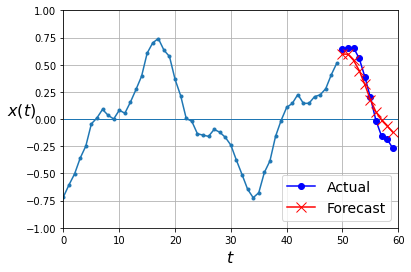

In [136]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

하지만 마지막 타임 스텝에서만 다음 값 10개를 예측하도록 모델을 훈련하는 대신 모든 타임 스텝에서 다음 값 10개를 예측하도록 모델을 훈련할 수 있음 => 시퀀스-투-시퀀스 RNN

* 마지막 타임 스텝에서의 출력뿐만 아니라 모든 타임 스텝에서 RNN 출력에 대한 항이 손실에 포함 됨

* 더 많은 오차 그래디언트가 모델로 흐르며, 시간에 따라 흐를 필요가 없음

* 훈련을 안정적으로 만들고 훈련 속도를 높임

#### **타깃 시퀀스 준비**

In [137]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

- 타임 스텝 0에서 모델이 타임 스텝 1에서 10까지 예측을 담은 벡터를 출력

- 그 후, 타임 스텝 1에서는 타임 스텝 2에서 11까지 예측

- 각 타깃은 입력 시퀀스와 동일한 길이의 시퀀스 (이 시퀀스는 타임 스텝마다 10차원 벡터를 담고 있음)

In [138]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [139]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

시퀀스-투-시퀀스 모델로 바꾸기 위해, 모든 순환 층에 return_sequences=True 로 지정

모든 타임 스텝에서 출력을 Dense 층에 적용 => TimeDistributed 층 사용

* 이 층은 다른 층을 감싸 입력 시퀀스의 모든 타임 스텝에 이를 적용
* 각 타임 스텝을 별개의 샘플처럼 다루도록 입력의 크기를 바꾸어 효과적으로 수행
* 그 후 Dense층에 적용
* 마지막으로 출력 크기를 시퀀스로 되돌림
* 여기서 Dense 층이 유닛을 10개 가지므로 출력 차원의 길이는 10

In [140]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 60s 262ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 58s 265ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0352 - val_last_time_step_mse: 0.0244
Epoch 3/20
219/219 [==============================] - 51s 235ms/step - loss: 0.0322 - last_time_step_mse: 0.0210 - val_loss: 0.0358 - val_last_time_step_mse: 0.0282
Epoch 4/20
219/219 [==============================] - 51s 235ms/step - loss: 0.0296 - last_time_step_mse: 0.0184 - val_loss: 0.0274 - val_last_time_step_mse: 0.0153
Epoch 5/20
219/219 [==============================] - 52s 240ms/step - loss: 0.0273 - last_time_step_mse: 0.0154 - val_loss: 0.0260 - val_last_time_step_mse: 0.0151
Epoch 6/20
219/219 [==============================] - 59s 271ms/step - loss: 0.0250 - last_time_step_mse: 0.0123 - val_loss: 0.0231 - val_last_time_step_mse: 0.0100
Epoch 7/20

- 훈련하는 동안은 모든 출력이 필요하지만, 예측/평가에는 마지막 타임 스텝의 출력만 사용 됨

- 평가를 위해 마지막 타임 스텝의 출력에 대한 MSE만을 계산하는 사용자 정의 지표 사용

- 검증 MSE로 0.006가 나옴 -> 이전 모델보다 25% 향상

- 이 RNN을 사용해 다음 값 10개를 예측하고, 이 값을 입력 시계열에 연결하고, 모델을 다시 사용해 다음 값 10개를 예측하는 방식을 반복할 수 있음 (어떤 길이의 시퀀스도 생성 가능) -> 16장에서 볼 새로운 음악이나 텍스트를 생성할 때 사용 가능

## 긴 시퀀스 다루기

긴 시퀀스로 RNN을 훈련하려면, 많은 타임 스텝에 걸쳐 실행해야 하므로 펼친 RNN이 매우 깊은 네트워크가 됨

1. 그래디언트 소실/폭주 문제가 있을 수 있음

2. 또한 RNN이 긴 시퀀스를 처리할 때 입력의 첫 부분을 조금씩 잊어버리게됨

#### 불안정한 그래디언트 문제와 싸우기

불안정한 그래디언트 문제를 완화하기 위해, 심층 신경망에서 사용했던 기법을 RNN에서 사용 가능

좋은 가중치 초기화, 빠른 옵티마이저, 드롭아웃

하지만 수렴하지 않는 활성화 함수는 RNN을 불안정하게 만듦

- 경사 하강법이 첫 번째 타임 스텝에서 출력을 조금 증가시키는 방향으로 가중치를 업데이트한다고 가정해보면,

- 동일한 가중치가 모든 타임 스텝에서 사용되므로 두 번째 타임 스텝의 출력도 조금 증가할 수 있고

- 그 후도 마찬가지 -> 출력이 폭주함

-> 수렴하지 않는 활성화 함수는 이를 막지 못함

-> 하이퍼볼릭 탄젠트 같은 수렴하는 활성화 함수를 사용하는 이유

배치 정규화는 심층 피드포워드 네트워크처럼 RNN과 효율적으로 사용할 수 없음

- 타임 스텝 사이에 사용할 수 없고, 순환 층 사이에만 가능함

- 엄청난 효과를 주지는 않음

-> RNN에서 잘 맞는 다른 종류의 정규화, 층 정규화

#### **층 정규화**

배치 차원에 대해 정규화하는 대신 특성 차원에 대해 정규화함

- 샘플에 독립적으로 타임 스텝마다 종적으로 필요한 통계를 계산할 수 있음

(훈련과 테스트에서 동일한 방식으로 작동한다는 것을 의미)

- 훈련 세트의 모든 샘플에 대한 특성 통계를 추정하기 위해 지수 이동 평균이 필요하지 않음

- 입력마다 하나의 스케일과 이동 파라미터를 학습함

- RNN에서 층 정규화는 보통 입력과 은닉 상태의 선형 조합 직후에 사용됨

#### **메모리 셀 안에 층 정규화 구현**

현재 타임 스텝의 inputs과 이전 타임 스텝의 은닉 states.

states 매개변수는 하나 이상의 텐서를 담은 리스트. 다른 셀의 경우에는 여러 상태 텐서를 가질 수 있음.

셀은 state_size, output_size 속성을 가져야 함. 간단한 RNN에서는 둘 다 모두 유닛수와 동일.

아래 코드는 SimpleRNNCell처럼 작동하는 사용자 정의 메모리 셀을 구현. 다른 점은 각 타임스텝마다 층 정규화.

In [141]:
from tensorflow.keras.layers import LayerNormalization

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

LNSimpleRNNCell 클래스는 다른 사용자 정의 층과 마찬가지로 keras.layers.Layer 클래스 상속.

생성자는 유닛 개수와 활성화 함수를 매개변수로 받고 state_size와 output_size 속성을 설정한 다음

활성화 함수 없이 SimpleRNNCell을 만듦(선형 연산 후와 활성화 함수 전에 층 정규화를 수행하기 위해).

|

그다음 생성자는 LayerNormalization 층을 만들고 마지막으로 원하는 활성화 함수를 선택.

call()은 먼저 간단한 RNN 셀을 적용해 현재 입력과 이전 은닉상태의 선형조합을 계산.

이 셀은 2개의 결과 반환. (하나는 출력, 다른 하나는 은닉 상태가 됨.)

In [142]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 126s 563ms/step - loss: 0.1581 - last_time_step_mse: 0.1519 - val_loss: 0.0721 - val_last_time_step_mse: 0.0639
Epoch 2/20
219/219 [==============================] - 126s 575ms/step - loss: 0.0628 - last_time_step_mse: 0.0516 - val_loss: 0.0552 - val_last_time_step_mse: 0.0369
Epoch 3/20
219/219 [==============================] - 123s 562ms/step - loss: 0.0517 - last_time_step_mse: 0.0349 - val_loss: 0.0488 - val_last_time_step_mse: 0.0329
Epoch 4/20
219/219 [==============================] - 116s 530ms/step - loss: 0.0459 - last_time_step_mse: 0.0306 - val_loss: 0.0433 - val_last_time_step_mse: 0.0285
Epoch 5/20
219/219 [==============================] - 124s 565ms/step - loss: 0.0418 - last_time_step_mse: 0.0271 - val_loss: 0.0407 - val_last_time_step_mse: 0.0254
Epoch 6/20
219/219 [==============================] - 126s 574ms/step - loss: 0.0387 - last_time_step_mse: 0.0232 - val_loss: 0.0366 - val_last_time_step_mse: 0.0204
Epoc

### 단기 기억 문제 해결하기

RNN을 거치면서 데이터가 변환되므로 일부 정보는 매 훈련 스텝 후 사라짐

- 어느 정도 지나면,  RNN의 상태는 사실상 첫 번재 입력의 흔적을 가지고 있지 않음

- 이는 번역같은 경우 문제가 될 수 있음

-> 장기 메모리를 가진 여러 종류의 셀이 연구됨

(요즘은 기본 셀이 많이 사용되지 않음)

#### **LSTM 셀**

Keras에서는 간단히 SimpleRNN 층 대신 LSTM 층을 사용하면 됨

In [143]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 9s 23ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0480 - last_time_step_mse: 0.0283 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0391 - last_time_step_mse: 0.0181 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0325 - last_time_step_mse: 0.0133 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0308 - last_time_step_mse: 0.0122 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [==

또는 범용 목적의 keras.layers.RNN 층에 LSTMCell을 매개변수로 지정할 수 있음

- LSTM층이 GPU 실행 시 최적화된 구현을 사용하므로 일반적으로 선호됨

In [144]:
'''
model = keras.models.Sequential([
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
'''

'\nmodel = keras.models.Sequential([\n    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True,\n                     input_shape=[None, 1]),\n    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True),\n    keras.layers.TimeDistributed(keras.layers.Dense(10))\n])\n'

In [145]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 8ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788688704371452, 0.008560803718864918]

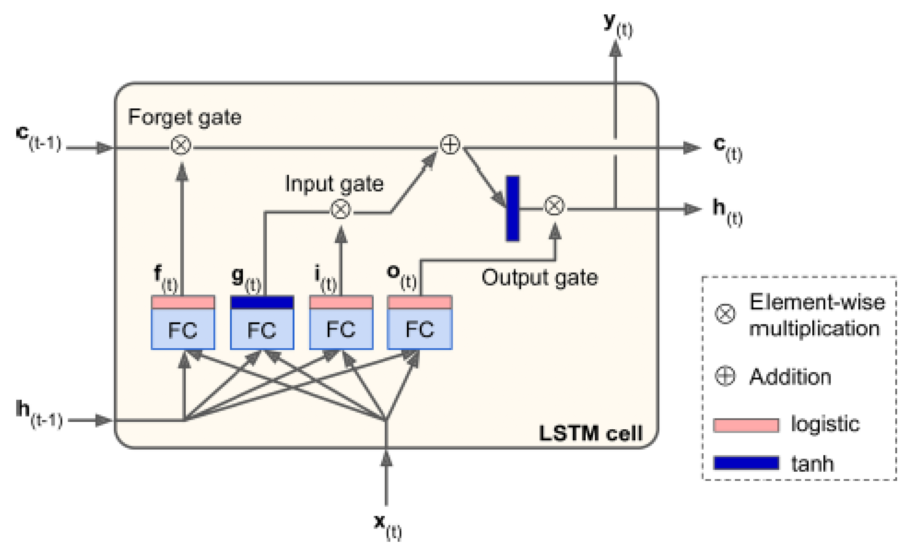

In [146]:
filename = "rnn_6.png"
images_path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
show_img = mpimg.imread(os.path.join(images_path, filename))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(show_img)

- 박스 내부를 보지 않는다면, 상태가 두 개의 벡터 h(t)와 c(t) (c는 셀)로 나뉜다는 것을 빼고는 일반 셀과 같음

- h(t)를 단기 상태, c(t)를 장기 상태라고 할 수 있음

- 내부 구조

  * 장기 기억 c(t-1)은 네트워크를 왼쪽에서 오른쪽으로 관통하면서, 삭제 게이트를 지나 일부 기억을 잃고, 그 후 덧셈 연산으로 새로운 기억 일부를 추가함(입력 게이트에서 선택한 기억을 추가함)

  * 만들어진 c(t)는 다른 추가 변환 없이 바로 출력으로 보내짐

  * -> 타임 스텝마다 일부 기억이 삭제되고 일부 기억이 추가됨

  * 또한 덧셈 연산 후 이 장기 상태가 복사되어 tanh 함수로 전달됨
  
  * 그 후 이 결과는 출력 게이트에 의해 걸러짐 -> 단기 상태 h(t) 생성

- 새로운 기억과 게이트의 작동

  * 현재 입력 벡터 x(t)와 이전의 단기 상태 h(t-1)이 네 개의 다른 완전 연결 층에 주입됨

  * 주 층은 g(t)를 출력하는 층 -> 현재 입력 x(t)와 이전의 단기 상태 h(t-1)을 분석하는 일반적인 역할 담당, 이 층의 출력이 곧 바로 나가지 않고, 장기 상태에 가장 중요한 부분이 저장됨

  * 세 개의 다른 층은 게이트 제어기

  * 삭제 게이트는 장기 상태의 어느 부분이 삭제되어야 하는지 제어

  * 입력 게이트는 어느 부분이 장기 상태에 더해져야 하는지 제어
  
  * 출력 게이트는 장기 상태의 어느 부분을 읽어서 이 타임스텝의 h(t)와 y(t)로 출력해야 하는지 제어

요약하자면, 

- LSTM 셀은 중요한 입력을 인식하고 (입력 게이트)

- 장기 상태에 저장하고

- 필요한 기간 동안 이를 보존하고 (삭제 게이트)

- 필요할 때마다 이를 추출하기 위해 학습

- $W_{x*}$ 는 입력벡터 x(t)에 각각 연결된 네 개 층의 가중치 행렬

- $W_{h*}$ 는 이전의 단기 상태 h(t-1)에 각각 연결된 네 개 층의 가중치 행렬

- $b_*$는 네 개 층 각각에 대한 편향

**Equation 14-3: LSTM computations**

$\begin{split}
\mathbf{i}_{(t)}&=\sigma({\mathbf{W}_{xi}}^T \mathbf{x}_{(t)} + {\mathbf{W}_{hi}}^T \mathbf{h}_{(t-1)} + \mathbf{b}_i)\\
\mathbf{f}_{(t)}&=\sigma({\mathbf{W}_{xf}}^T \mathbf{x}_{(t)} + {\mathbf{W}_{hf}}^T \mathbf{h}_{(t-1)} + \mathbf{b}_f)\\
\mathbf{o}_{(t)}&=\sigma({\mathbf{W}_{xo}}^T \mathbf{x}_{(t)} + {\mathbf{W}_{ho}}^T \mathbf{h}_{(t-1)} + \mathbf{b}_o)\\
\mathbf{g}_{(t)}&=\operatorname{tanh}({\mathbf{W}_{xg}}^T \mathbf{x}_{(t)} + {\mathbf{W}_{hg}}^T \mathbf{h}_{(t-1)} + \mathbf{b}_g)\\
\mathbf{c}_{(t)}&=\mathbf{f}_{(t)} \otimes \mathbf{c}_{(t-1)} \, + \, \mathbf{i}_{(t)} \otimes \mathbf{g}_{(t)}\\
\mathbf{y}_{(t)}&=\mathbf{h}_{(t)} = \mathbf{o}_{(t)} \otimes \operatorname{tanh}(\mathbf{c}_{(t)})
\end{split}
$

#### **핍홀 연결**

LSTM 셀에서 게이트 제어기는 입력 x(t)와 이전 단기 상태 h(t-1)만 바라봄 

-> 게이트 제어기에 장기 상태도 노출시켜 더 많은 문맥을 감지하게 하고자함

=> 핍홀 연결 이라 부르는 추가적인 연결이 있는 LSTM 변종이 제안됨

|

- 이전 장기 기억 상태 c(t-1)이 삭제 게이트와 입력 게이트의 제어기 f(t)와 i(t)에 입력으로 추가됨

- 현재의 장기 기억 상태 c(t)는 출력 게이트의 제어기 o(t)에 입력으로 추가됨

-> 성능을 향상시키는 경우가 많지만, 항상 그렇지는 않음

- 케라스에서는 tf.keras.experimental.PeepholeLSTMCell 사용 가능 

#### **GRU 셀**

게이트 순환 유닛 (GRU) 셀은 LSTM 셀의 간소화 버전

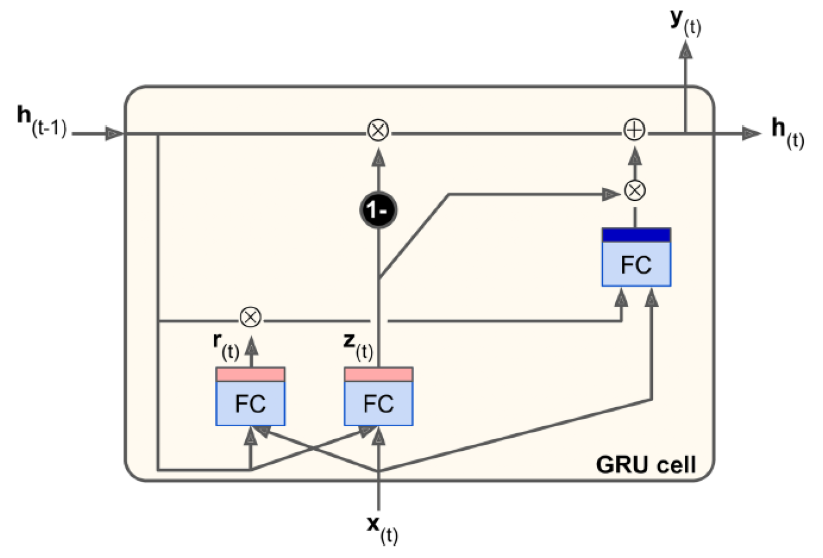

In [147]:
filename = "rnn_7.png"
images_path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
show_img = mpimg.imread(os.path.join(images_path, filename))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(show_img)

- 두 상태 벡터가 하나의 벡터 h(t)로 합쳐짐

- 하나의 게이트 제어기 z(t)가 삭제 게이트와 입력 게이트 모두 제어

  * 게이트 제어기가 1을 출력하면 삭제 게이트가 열리고(=1) 입력 게이트가 닫힘(1-1=0)
  * 게이트 제어기가 0을 출력하면 그 반대
  * -> 기억이 저장될 때마다 저장될 위치가 먼저 삭제됨

- 출력 게이트가 없음

  * 전체 상태 벡터가 매 타임 스텝마다 출력됨
  * 이전 상태의 어느 부분이 주 층에 노출될지 제어하는 새로운 게이트 제어기 r(t)가 있음

**Equation 14-4: GRU computations**

$\begin{split}
\mathbf{z}_{(t)}&=\sigma({\mathbf{W}_{xz}}^T \mathbf{x}_{(t)} + {\mathbf{W}_{hz}}^T \mathbf{h}_{(t-1)}) \\
\mathbf{r}_{(t)}&=\sigma({\mathbf{W}_{xr}}^T \mathbf{x}_{(t)} + {\mathbf{W}_{hr}}^T \mathbf{h}_{(t-1)}) \\
\mathbf{g}_{(t)}&=\operatorname{tanh}\left({\mathbf{W}_{xg}}^T \mathbf{x}_{(t)} + {\mathbf{W}_{hg}}^T (\mathbf{r}_{(t)} \otimes \mathbf{h}_{(t-1)})\right) \\
\mathbf{h}_{(t)}&=(1-\mathbf{z}_{(t)}) \otimes \mathbf{h}_{(t-1)} + \mathbf{z}_{(t)} \otimes \mathbf{g}_{(t)}
\end{split}
$


- 케라스는 keras.layers.GRU 층을 제공함

LSTM과 GRU 셀은 RNN 성공의 주역

- 단순한 RNN보다 훨씬 긴 시퀀스를 다루지만, 매우 제한적인 단기 기억을 가짐

- 100 타임스텝 이상의 시퀀스에서 장기 패턴을 학습하는 데 어려움을 해결하기 위해, 1D 합성곱 층을 통해 입력 시퀀스를 짧게 줄일 수 있음

 

#### **1D 합성곱 층을 사용해 시퀀스 처리하기**

1D 합성곱 층이 몇 개의 커널을 시퀀스 위를 슬라이딩하여 커널마다 1D 특성 맵을 출력함

- 각 커널은 매우 짧은 하나의 순차 패턴을 감지하도록 학습

- 10개의 커널을 사용하면 이 층의 출력은 10개의 1차원 시퀀스로 구성됨(= 10차원 시퀀스)

-> 순환 층과 1D 합성곱 층(또는 심지어 1D 풀링 층)

앞 모델과 같도록 합성곱 층을 사용한 코드

In [148]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 8s 19ms/step - loss: 0.0681 - last_time_step_mse: 0.0601 - val_loss: 0.0477 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0414 - last_time_step_mse: 0.0340 - val_loss: 0.0367 - val_last_time_step_mse: 0.0285
Epoch 3/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0338 - last_time_step_mse: 0.0257 - val_loss: 0.0307 - val_last_time_step_mse: 0.0218
Epoch 4/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0282 - last_time_step_mse: 0.0184 - val_loss: 0.0259 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0249 - last_time_step_mse: 0.0143 - val_loss: 0.0246 - val_last_time_step_mse: 0.0141
Epoch 6/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0234 - last_time_step_mse: 0.0125 - val_loss: 0.0227 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [==

- 스트라이드 2를 사용해 입력 시퀀스를 두 배로 다운샘플링하는 1D 합성곱층 사용

- 커널 크기가 스트라이드보다 크므로, 모든 입력을 사용해 이 층의 출력을 계산 함

-> 모델이 중요하지 않은 건 버리고, 유용한 정보를 보존하도록 학습

- 합성곱 층으로 시퀀스 길이를 줄이면, GRU 층이 더 긴 패턴을 감지하는 데 도움이 됨

-> 타깃에서 처음 세 개의 타임 스텝을 버리고 두 배로 다운 샘플해야 함

(커널 크기가 4이므로 합성곱 층의 첫 출력은 0~3까지 타임스텝으로 만들어짐)

#### **WaveNet**

층마다 팽창 비율(각 뉴런의 입력이 떨어져 있는 간격)을 두 배로 늘리는 1D 합성곱 층을 쌓음

- 첫 번째 합성곱 층이 한 번에 2개의 타임 스텝만 바라봄

- 다음 층은 4개의 타임 스텝을 보고 다음은 8개의 타임 스텝을 보는 식

-> 하위 층은 단기 패턴 학습, 상위 층은 장기 패턴 학습

-> 긴 시퀀스를 매우 효율적으로 처리할 수 있음

WaveNet은 실제로 팽창 비율이 1,2,4...,512인 합성곱 층 10개를 쌓고, 동일한 층 10개를 따로 그룹지어 쌓았음

-> 이런 팽창 비율을 가진 합성곱 층 10개가 1024 크기의 커널 한 개로 이루어진 매우 효율적인 합성곱 층처럼 작동한다는 것을 보였음 (빠르고 강력, 적은 파라미터 사용)

앞과 동일한 시퀀스를 처리하는 간단한 WaveNet 구현

In [149]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 16ms/step - loss: 0.0668 - last_time_step_mse: 0.0543 - val_loss: 0.0365 - val_last_time_step_mse: 0.0230
Epoch 2/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0323 - last_time_step_mse: 0.0193 - val_loss: 0.0294 - val_last_time_step_mse: 0.0166
Epoch 3/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0283 - last_time_step_mse: 0.0156 - val_loss: 0.0269 - val_last_time_step_mse: 0.0144
Epoch 4/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0261 - last_time_step_mse: 0.0136 - val_loss: 0.0254 - val_last_time_step_mse: 0.0130
Epoch 5/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0248 - last_time_step_mse: 0.0124 - val_loss: 0.0244 - val_last_time_step_mse: 0.0122
Epoch 6/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0240 - last_time_step_mse: 0.0117 - val_loss: 0.0233 - val_last_time_step_mse: 0.0108
Epoch 7/20
219/219 [==

이 Sequential 모델은 명시적인 입력층으로 시작(이 방식이 for문 안의 첫번째 층에만 input_shape을 넣는 것보다 간단).

이렇게 하면 합성곱 층이 예측을 만들 때 미래의 시퀀스를 훔쳐보게 되지 않음(이는 입력의 왼쪽에 0을 알맞게 패딩하고
"vaild" 패딩을 사용하는 것과 같음).

이때 동일하게 팽창비율이 늘어나는 일련의 층을 반복. 즉 팽창비율 1,2,4,8의 층을 추가하고

다시 팽창비율 1,2,4,8의 층을 추가. 마지막으로 출력층 추가.

이 층은 크기가 1인 필터 10개를 사용하고 활성화함수가 없는 합성곱 층.

- 층에 추가한 패딩 덕분에, 모든 합성곱 층은 입력 시퀀스의 길이와 동일한 시퀀스를 출력

-> 훈련하는 동안 전체 시퀀스를 타깃으로 사용할 수 있음

(잘라내거나 다운샘플링할 필요가 없음)